# Position encodings

> Implementation of special position encodings.

In [ ]:
#| default_exp models.position_encoding

In [ ]:
#| export
from genQC.imports import *

## p-RoPE

In [ ]:
#| export
class RotaryPositionalEmbedding(nn.Module):
    """
    This class implements the Rotary Positional Embeddings (RoPE),
    proposed in https://arxiv.org/abs/2104.09864.

    Code adjusted from https://github.com/pytorch/torchtune/blob/main/torchtune/modules/position_embeddings.py
    > Copyright (c) Meta Platforms, Inc. and affiliates.
    > All rights reserved.

    Additionally adds p-RoPE from https://openreview.net/pdf?id=GtvuNrk58a
    Note: p=0 coincides with NoPE, while the case p=1 with RoPE
    """

    def __init__(self, head_dim: int, p: float = 1.0, max_seq_len: int = 4096, base: float = 10_000) -> None:
        super().__init__()
        self.head_dim    = head_dim
        self.p           = p 
        self.base        = base              # max_wavelength; the lowest frequencies rotate at roughly 1/base radians per token; i.e. we can resolve 2pi*base tokens
        self.max_seq_len = max_seq_len

        self.rope_angles = int(self.p * (self.head_dim//2))  #division factor two is for cos-sin split
        self.nope_angles = self.head_dim//2 - self.rope_angles

        timescale  = self.base ** (2.0 * torch.arange(0, self.head_dim//2, dtype=torch.float32) / self.head_dim)
        timescale[self.rope_angles:] = torch.full((self.nope_angles,), fill_value=torch.inf, dtype=torch.float32)

        theta = 1.0 / timescale
        
        self.register_buffer("theta", theta, persistent=False)
        self.rebuild_rope_cache(self.max_seq_len)
 
    def rebuild_rope_cache(self, max_seq_len: int = 4096) -> None:
        
        # Create position indexes [0, 1, ..., max_seq_len - 1]
        seq_idx = torch.arange(max_seq_len, dtype=self.theta.dtype, device=self.theta.device)

        # Outer product of theta and position index: output shape [max_seq_len, head_dim//2]
        idx_theta = torch.einsum("i, j -> ij", seq_idx, self.theta)

        # cache includes both the cos and sin: output shape [max_seq_len, head_dim//2, 2]
        rope_cache = torch.stack([torch.cos(idx_theta), torch.sin(idx_theta)], dim=-1)
        self.register_buffer("rope_cache", rope_cache, persistent=False)

    def forward(self, x: torch.Tensor, pos_idx: Optional[torch.Tensor] = None) -> torch.Tensor:
        """
        Shape:
            x       ... [b, seq, n_heads, head_dim]
            pos_idx ... [b, seq] or [seq]
        """
        
        seq_len = x.size(1)
        xshaped = x.type_as(self.rope_cache).reshape(*x.shape[:-1], -1, 2)  #split head_dim [b, seq, n_h, head_dim/2, 2]
        
        # extract the values based on whether pos_idx is set or not, shape [seq, head_dim/2, 2]
        if exists(pos_idx):
            rope_cache = self.rope_cache[pos_idx]
            
            # reshape the cache to [b, seq, 1, head_dim/2, 2]
            rope_cache = rope_cache.view(-1, seq_len, 1, xshaped.size(3), 2)

        else:
            rope_cache = self.rope_cache[:seq_len]
            
            # reshape the cache to [1, seq, 1, head_dim/2, 2]
            rope_cache = rope_cache.view(1, seq_len, 1, xshaped.size(3), 2) 

        # out has shape [b, seq, n_h, head_dim/2, 2]
        x_out = torch.stack(
            [
                xshaped[..., 0] * rope_cache[..., 0] - xshaped[..., 1] * rope_cache[..., 1],  # x cos - y sin
                xshaped[..., 1] * rope_cache[..., 0] + xshaped[..., 0] * rope_cache[..., 1],  # x sin + y cos
            ], dim=-1)

        # flatten to shape [b, seq, n_h, head_dim]
        x_out = x_out.flatten(3)
        return x_out.type_as(x)

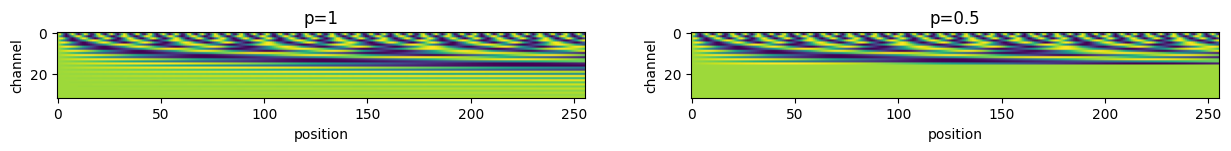

In [ ]:
b = 1
s = 256
n_heads = 1
head_dim = 32
q = torch.ones((b, s, n_heads, head_dim))

p1 = 1
p2 = 0.5

pe = RotaryPositionalEmbedding(head_dim, p1)
q_pe1 = pe(q).squeeze() # [s, head_dim]

pe = RotaryPositionalEmbedding(head_dim, p2)
q_pe2 = pe(q).squeeze() # [s, head_dim]

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.imshow(q_pe1.T) 
ax1.set_title(f"p={p1}")
ax1.set_xlabel("position")
ax1.set_ylabel("channel")
ax2.imshow(q_pe2.T) 
ax2.set_title(f"p={p2}")
ax2.set_xlabel("position")
ax2.set_ylabel("channel")
plt.show()

## 2d p-RoPE

In [ ]:
#| export
class RotaryPositionalEmbedding2D(nn.Module):
    
    def __init__(self, head_dim: int, p: float = 1.0, max_seq_len: int = 4096, base: float = 10_000) -> None:
        super().__init__()
        self.rope = RotaryPositionalEmbedding(head_dim=head_dim//2, p=p, max_seq_len=max_seq_len, base=base)

    def forward(self, x: torch.Tensor, pos_idx: torch.Tensor) -> torch.Tensor:
        """
        The tensor `pos_idx` specifies the x and y coordinates of sequence elements of x.
        
        Shape:
            x       ... [b, seq, n_heads, head_dim]
            pos_idx ... [b, seq, 2] or [seq, 2]
        """

        xshaped = x.reshape(*x.shape[:-1], -1, 2)  #split head_dim [b, seq, n_h, head_dim/2, 2]

        x_out = torch.cat(
            [
                self.rope(xshaped[..., 0], pos_idx=pos_idx[..., 0]),  # coord 1
                self.rope(xshaped[..., 1], pos_idx=pos_idx[..., 1]),  # coord 2
            ], dim=-1) 
        
        return x_out

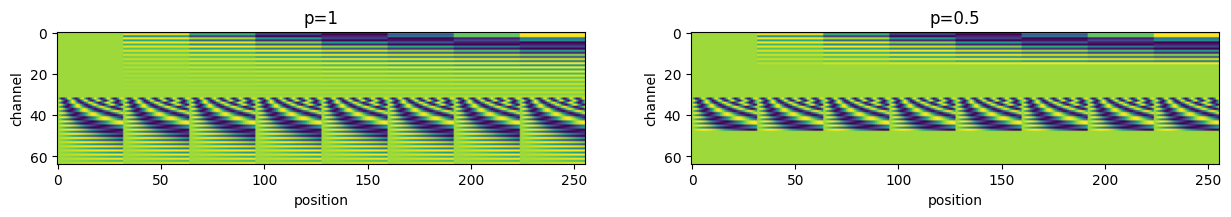

In [ ]:
b = 1
s = 256
n_heads = 1
head_dim = 64
q = torch.ones((b, s, n_heads, head_dim))

nx = 32
ny = 8
px = torch.arange(nx).expand(ny, -1)
py = torch.arange(ny).unsqueeze(-1).expand(-1, nx)
pos_idx = torch.stack([py, px], dim=-1).reshape(-1, 2)

p1 = 1
p2 = 0.5
base = 100

pe = RotaryPositionalEmbedding2D(head_dim, p1, base=base)
q_pe1 = pe(q, pos_idx).squeeze() # [s, head_dim]

pe = RotaryPositionalEmbedding2D(head_dim, p2, base=base)
q_pe2 = pe(q, pos_idx).squeeze() # [s, head_dim]

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.imshow(q_pe1.T) 
ax1.set_title(f"p={p1}")
ax1.set_xlabel("position")
ax1.set_ylabel("channel")
ax2.imshow(q_pe2.T) 
ax2.set_title(f"p={p2}")
ax2.set_xlabel("position")
ax2.set_ylabel("channel")
plt.show()

## Learned position encoding

In [ ]:
#| export
class LearnedPositionalEmbedding(nn.Module):
    """
    This class implements a Learned Positional Embedding, e.g. used for spatial circuit dimension.
    """
    
    def __init__(self, dim: int, max_seq_len: int = 64) -> None:
        super().__init__()

        self.dim = dim
        self.max_seq_len = max_seq_len
        
        _pos_encoding     = torch.zeros((self.max_seq_len, self.dim), dtype=torch.float32)
        self.pos_encoding = nn.Parameter(_pos_encoding)
    
        self._init_weights()
   
    def _init_weights(self) -> None:
        nn.init.orthogonal_(self.pos_encoding)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Assumes channel last.
        
        Shapes:
            x  ... [b, s, t, ch]
        """

        seq_len = x.shape[1]
        
        pos_encoding = self.pos_encoding[:seq_len].view(1, seq_len, 1, -1)  # to [1, s, 1, ch]
        x = x + pos_encoding
        
        return x

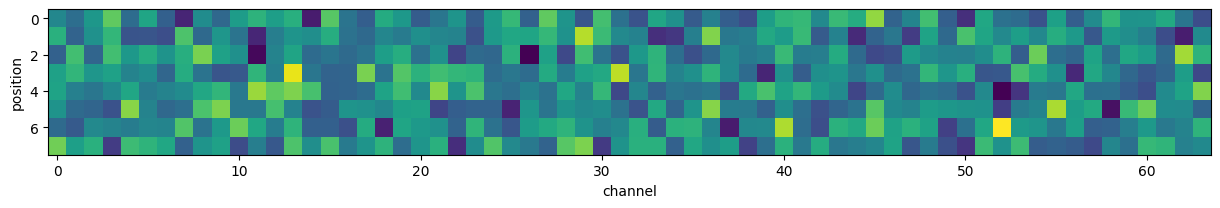

In [ ]:
b = 1
s = 8
t = 1
dim = 64

pe = LearnedPositionalEmbedding(dim)

q = torch.zeros((b, s, t, dim))
q = pe(q).squeeze() # [s, dim]

plt.figure(figsize=(15, 5))
plt.imshow(q.detach()) 
plt.xlabel("channel")
plt.ylabel("position")
plt.show()

# Export -

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()